In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import when, count, isnull
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import FloatType

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.functions import vector_to_array

import pyspark.sql.functions as F

spark = SparkSession.Builder().appName('DDAM_Project_south').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/13 22:01:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/South_Incidents_Cleaned.csv')
#df.show()

Preparing data for MLP classification

In [6]:
to_drop=['Start_Time','City','County','State','Wind_Direction','day_of_the_week','season']
df_class=df.drop(*to_drop)
colonne_booleane = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Converti le colonne booleane in numeriche
for col_name in colonne_booleane:
    df_class = df_class.withColumn(col_name, col(col_name).cast("int"))


df_class = df_class.withColumn("Astronomical_Twilight", when(df_class["Astronomical_Twilight"] == 'Day', 0).otherwise(1))
df_class = df_class.withColumn("Working_Weekend", when(df_class["Working_Weekend"] == 'WorkingDay', 0).otherwise(1))




indexer = StringIndexer(inputCol='Weather_Condition', outputCol='class_numeric')
indexer_fitted = indexer.fit(df_class)
df_indexed = indexer_fitted.transform(df_class)


encoder = OneHotEncoder(inputCols=['class_numeric'], outputCols=['class_onehot'],dropLast=False)
df_onehot = encoder.fit(df_indexed).transform(df_indexed)


df_col_onehot = df_onehot.select('*', vector_to_array('class_onehot').alias('col_onehot'))

num_categories = len(df_col_onehot.first()['col_onehot'])   # 3
cols_expanded = [(F.col('col_onehot')[i].alias(f'{indexer_fitted.labels[i]}')) for i in range(num_categories)]
df_cols_onehot = df_col_onehot.select('Severity',
 'Start_Lat',
 'Start_Lng',
 'Distance_mi',
 'Temperature_F',
 'Humidity_perc',
 'Visibility_mi',
 'Wind_Speed_mph',
 'Precipitation_in',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'month',
 'hour',
 'Working_Weekend',
 'Astronomical_Twilight', *cols_expanded)


num_col = [item[0] for item in df_cols_onehot.dtypes if not item[1].startswith('string')]
num_col.remove("Severity")

df_MLP= df_cols_onehot.withColumn("Severity", col("Severity") - 1)
df_MLP.show()

23/12/13 22:01:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+------------------+-------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+------+------+----+-----+----+
|Severity|         Start_Lat|          Start_Lng|       Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|Normal|Cloudy|Rain|Foggy|Snow|
+--------+------------------+-------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+------+------+----+-----+----+
|

In [7]:
df_MLP_binary=df_MLP

Discovering Severity distribution before train e test split

In [8]:
severity_counts = df_MLP.groupBy("Severity").count()
severity_counts.show()

+--------+------+
|Severity| count|
+--------+------+
|       1|153857|
|       3|  2803|
|       2| 11752|
|       0|  5186|
+--------+------+



Vectorizing data with respect to Severity

In [8]:
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_MLP)

classificationData = output_dataset.select("features", "Severity")

classificationData.show(truncate=False)
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

+--------------------------------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                                        |Severity|
+--------------------------------------------------------------------------------------------------------------------------------+--------+
|(29,[0,1,2,3,4,5,6,20,21,23,24],[33.28583836539609,-110.35937190003224,2.735,56.0,12.0,10.0,10.0,4.0,3.0,1.0,1.0])              |1       |
|(29,[0,1,2,3,4,5,6,20,21,23,24],[32.603849172436696,-109.68630909867436,1.5659999999999998,75.0,27.0,10.0,9.0,4.0,22.0,1.0,1.0])|1       |
|(29,[0,1,2,3,4,5,6,20,21,23,24],[32.816642,-109.671375,0.083,73.0,11.0,10.0,10.0,4.0,23.0,1.0,1.0])                             |1       |
|(29,[0,1,2,3,4,5,6,20,21,24],[32.573706,-109.833815,0.995,67.0,15.0,10.0,20.0,3.0,16.0,1.0])                                    |1       |
|(29,[0,1,2,3,4,5,6,

Discovering Severity trainingData e testData distribution

In [10]:
severity_counts_train= trainingData.groupBy("Severity").count()
severity_counts_train.show()

+--------+------+
|Severity| count|
+--------+------+
|       1|108010|
|       3|  1940|
|       2|  8198|
|       0|  3676|
+--------+------+



In [11]:
severity_counts_test= testData.groupBy("Severity").count()

# Mostra il risultato
severity_counts_test.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|45847|
|       3|  863|
|       2| 3554|
|       0| 1510|
+--------+-----+



### Training & Testing a non tuned MLP with trainingData  not yet sampled

In [23]:
# MLP Layers  -> output layer must have the same number of units of the Severity classes
layers = [len(num_col),4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Severity",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(trainingData)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}
')
print("Test Error = %g" % (1.0 - accuracy))


23/12/13 10:59:53 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
23/12/13 10:59:53 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
23/12/13 10:59:54 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
23/12/13 10:59:55 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
23/12/13 10:59:55 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.125
23/12/13 10:59:55 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.09375
23/12/13 10:59:59 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
23/12/13 11:00:01 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
23/12/13 11:00:01 

Accuracy:0.8863329084096264

Test Error = 0.113667


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 53.41%
Recall for class  0 : 9.87%
avg_F1-Score for class  0 : 16.66%
----------------------------
Precision for class  1 : 88.82%
Recall for class  1 : 99.77%
avg_F1-Score for class  1 : 93.98%
----------------------------
Precision for class  2 : 0.00%
Recall for class  2 : 0.00%
avg_F1-Score for class  2 : 0.00%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.16657350475125768, 0.9397793347167719, 0.0, 0.0]
----------------------
avg_F1-Score: 27.66%


<Axes: >

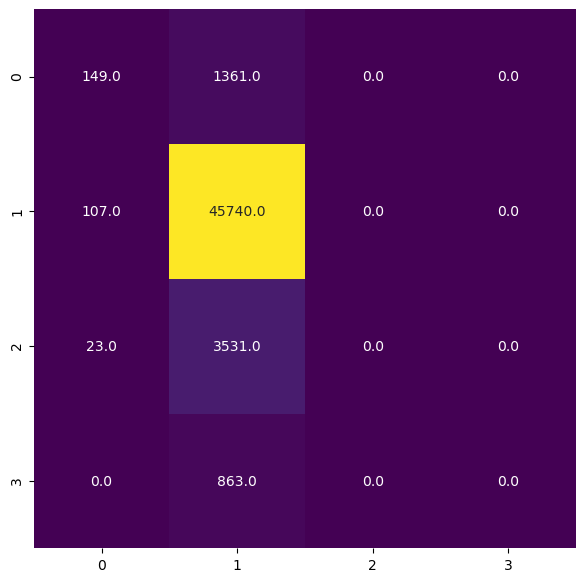

In [24]:
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Performing Undersampling(Severity=1) on trainingData

Undersampling -> Faccio una media delle occorrenze delle altre tre classi e riduco la classe di maggioranza a quel numero

In [9]:
g=trainingData.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g_p=g.toPandas()
n_0=g_p.iloc[0,1]
n_1=g_p.iloc[1,1]
n_2=g_p.iloc[2,1]
n_3=g_p.iloc[3,1]

In [10]:
und=(n_0+n_2+n_3)/3
train_und = trainingData.sampleBy('Severity', fractions={0:1.0 ,1: und/n_1 , 2:1.0, 3:1.0})
result_counts=train_und.groupBy("Severity").count()
result_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 4601|
|       3| 1990|
|       2| 8228|
|       0| 3683|
+--------+-----+



Training & Testing a non tuned MLP with trainingData sampled

In [10]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

23/12/13 08:33:14 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
23/12/13 08:33:14 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
23/12/13 08:33:15 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
23/12/13 08:33:15 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
23/12/13 08:33:15 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.125
23/12/13 08:33:15 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.0625
23/12/13 08:33:16 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.046875
23/12/13 08:33:17 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
23/12/13 08:33

Accuracy:0.44124464016687914

Test Error = 0.558755


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 21.78%
Recall for class  0 : 70.40%
avg_F1-Score for class  0 : 33.27%
----------------------------
Precision for class  1 : 96.68%
Recall for class  1 : 40.85%
avg_F1-Score for class  1 : 57.43%
----------------------------
Precision for class  2 : 11.47%
Recall for class  2 : 84.41%
avg_F1-Score for class  2 : 20.20%
----------------------------
Precision for class  3 : 3.92%
Recall for class  3 : 6.26%
avg_F1-Score for class  3 : 4.82%
----------------------------
[0.33270735524256656, 0.5743111669912142, 0.20202700427623824, 0.04821428571428571]
----------------------
avg_F1-Score: 28.93%


<Axes: >

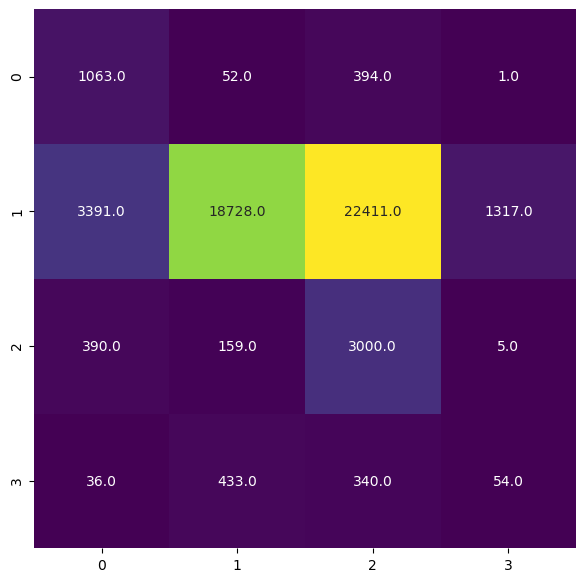

In [14]:
# MLP Layers  -> output layer must have the same number of units of the Severity classes
layers = [len(num_col),4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Severity",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(train_und)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}
')
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Performing Undersampling(Severity=1) & Oversampling(Severity=0,2,3) 

In [11]:
under_1=trainingData.filter(col('Severity') == 1)
under_1 = trainingData.sample(True, 0.3, seed=42)

In [12]:
oversample_0=trainingData.filter(col('Severity') == 0)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_0)/n_0 
full_0=oversample_0

while num_campioni_da_generare>1:
    oversample_0 = oversample_0.unionAll(full_0)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_0.sample(True, num_campioni_da_generare, seed=42)

oversample_0 = oversample_0.unionAll(df_minority_oversampled)

6.7846863969590006
5.7846863969590006
4.7846863969590006
3.7846863969590006
2.7846863969590006
1.7846863969590006
0.7846863969590006


In [13]:
oversample_2=trainingData.filter(col('Severity') == 2)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_2)/n_2
full_2=oversample_2

while num_campioni_da_generare>1:
    oversample_2 = oversample_2.unionAll(full_2)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_2.sample(True, num_campioni_da_generare, seed=42)

oversample_2 = oversample_2.unionAll(df_minority_oversampled)

1.9321827904715607
0.9321827904715607


In [14]:
oversample_3=trainingData.filter(col('Severity') == 3)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_3)/n_3  
full_3=oversample_3

while num_campioni_da_generare>1:
    oversample_3 = oversample_3.unionAll(full_3)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_3.sample(True, num_campioni_da_generare, seed=42)

oversample_3 = oversample_3.unionAll(df_minority_oversampled)

14.258291457286433
13.258291457286433
12.258291457286433
11.258291457286433
10.258291457286433
9.258291457286433
8.258291457286433
7.2582914572864325
6.2582914572864325
5.2582914572864325
4.2582914572864325
3.2582914572864325
2.2582914572864325
1.2582914572864325
0.25829145728643255


In [15]:
class0_counts=oversample_0.count()
class2_counts=oversample_2.count()
class3_counts=oversample_3.count()
class1_counts=under_1.count()
print(f'Class 0: {class0_counts}
Class 1: {class1_counts}
Class 2: {class2_counts}
Class 3: {class3_counts}')

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=57276Kb max_used=57738Kb free=73795Kb
 bounds [0x00000001089d8000, 0x000000010c298000, 0x00000001109d8000]
 total_blobs=17720 nmethods=16694 adapters=937
 compilation: disabled (not enough contiguous free space left)


23/12/13 21:41:54 WARN DAGScheduler: Broadcasting large task binary with size 1040.9 KiB


Class 0: 32359
Class 1: 36700
Class 2: 32367
Class 3: 32390


In [16]:
train_und_over=oversample_0.unionAll(oversample_2).unionAll(oversample_3).unionAll(under_1)

In [17]:
g=train_und_over.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g.show()

23/12/13 21:42:09 WARN DAGScheduler: Broadcasting large task binary with size 1864.7 KiB


+--------+-----+
|Severity|Count|
+--------+-----+
|       0|33487|
|       1|32564|
|       2|34761|
|       3|33004|
+--------+-----+



Training a tuned MLP with trainingData sampled

23/12/13 08:48:28 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:55:07 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:55:53 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:55:54 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:56:26 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:56:28 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:57:03 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:57:05 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:57:45 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:57:48 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:58:32 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 08:58:35 WARN DAGScheduler: Broadcasting larg

Accuracy:{accuracy}

Test Error = 0.941554


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 11.35%
Recall for class  0 : 90.73%
avg_F1-Score for class  0 : 20.17%
----------------------------
Precision for class  1 : 0.00%
Recall for class  1 : 0.00%
avg_F1-Score for class  1 : 0.00%
----------------------------
Precision for class  2 : 15.33%
Recall for class  2 : 25.69%
avg_F1-Score for class  2 : 19.20%
----------------------------
Precision for class  3 : 2.20%
Recall for class  3 : 86.10%
avg_F1-Score for class  3 : 4.29%
----------------------------
[0.20172274166237206, 0.0, 0.19204880100967608, 0.04293556775498412]
----------------------
avg_F1-Score: 10.92%


<Axes: >

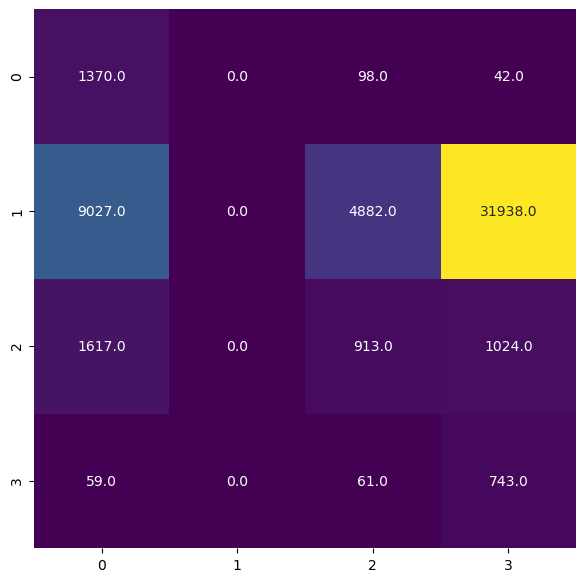

In [22]:
# MLP Layers  -> output layer must have the same number of units of the Severity classes
layers = [len(num_col),16,32,16,8,4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    blockSize=128,
    labelCol="Severity",
    featuresCol="features",
    maxIter=100
)

# Train the model
model = trainer.fit(train_und_over)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print('Accuracy:{accuracy}
')
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

23/12/13 21:43:10 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:26 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/13 21:43:27 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:28 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:33 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:34 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:35 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:35 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:37 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:37 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/13 21:43:38 WARN DAGSchedul

Accuracy:0.27499083878184727

Test Error = 0.725009


Precision for class  0 : 17.97%
Recall for class  0 : 86.63%
avg_F1-Score for class  0 : 29.76%
----------------------------
Precision for class  1 : 96.11%
Recall for class  1 : 21.88%
avg_F1-Score for class  1 : 35.65%
----------------------------
Precision for class  2 : 14.01%
Recall for class  2 : 67.99%
avg_F1-Score for class  2 : 23.23%
----------------------------
Precision for class  3 : 2.88%
Recall for class  3 : 60.39%
avg_F1-Score for class  3 : 5.51%
----------------------------
[0.29763401531603617, 0.35651942993715147, 0.2322830828889966, 0.055063362117304025]
----------------------
avg_F1-Score: 23.54%


<AxesSubplot:>

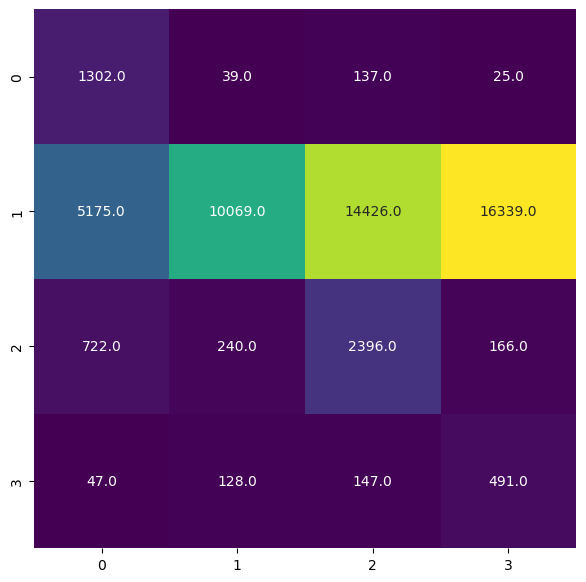

In [18]:
# MLP Layers  -> output layer must have the same number of units of the Severity classes
layers = [len(num_col),4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Severity",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(train_und_over)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}
')
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

MLP with Working_Weekend target

In [11]:
num_col = [item[0] for item in df_cols_onehot.dtypes if not item[1].startswith('string')]
num_col.remove('Working_Weekend')

In [12]:
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_MLP_binary)

classificationData = output_dataset.select("features", "Working_Weekend")

classificationData.show(truncate=False)
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

+--------------------------------------------------------------------------------------------------------------------------------------+---------------+
|features                                                                                                                              |Working_Weekend|
+--------------------------------------------------------------------------------------------------------------------------------------+---------------+
|(29,[0,1,2,3,4,5,6,7,21,22,23,24],[1.0,33.28583836539609,-110.35937190003224,2.735,56.0,12.0,10.0,10.0,4.0,3.0,1.0,1.0])              |0              |
|(29,[0,1,2,3,4,5,6,7,21,22,23,24],[1.0,32.603849172436696,-109.68630909867436,1.5659999999999998,75.0,27.0,10.0,9.0,4.0,22.0,1.0,1.0])|0              |
|(29,[0,1,2,3,4,5,6,7,21,22,23,24],[1.0,32.816642,-109.671375,0.083,73.0,11.0,10.0,10.0,4.0,23.0,1.0,1.0])                             |0              |
|(29,[0,1,2,3,4,5,6,7,21,22,24],[1.0,32.573706,-109.833815,0.995,67.0,15.0,10.0,20

In [13]:
from pyspark.sql import functions as F
g=trainingData.groupBy('Working_Weekend').agg(F.count('Working_Weekend').alias('Count'))
g=g.sort('Working_Weekend')
#g.show()
g_p=g.toPandas()
n_0=g_p.iloc[0,1]
n_1=g_p.iloc[1,1]

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy:0.8118360567080002

Test Error = 0.188164


Precision for class  0 : 81.18%
Recall for class  0 : 100.00%
avg_F1-Score for class  0 : 89.61%
----------------------------
Precision for class  1 : 0.00%
Recall for class  1 : 0.00%
avg_F1-Score for class  1 : 0.00%
----------------------------
[0.896147367972198, 0.0]
----------------------
avg_F1-Score: 44.81%


<Axes: >

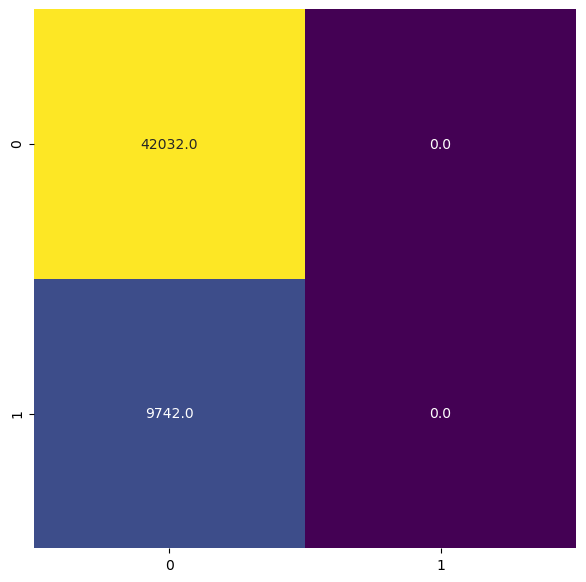

In [26]:
# MLP Layers  -> output layer must have the same number of units of the Working_Weekend classes
layers = [len(num_col),16,8,4,2]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Working_Weekend",
    featuresCol="features",
    maxIter=100,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(trainingData)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}
')
print("Test Error = %g" % (1.0 - accuracy))



# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Undersampling

In [27]:
train_und = trainingData.sampleBy('Working_Weekend', fractions={0:n_1/n_0 ,1: 1})

Accuracy:0.6601576080658246

Test Error = 0.339842


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 85.15%
Recall for class  0 : 70.42%
avg_F1-Score for class  0 : 77.09%
----------------------------
Precision for class  1 : 26.93%
Recall for class  1 : 47.03%
avg_F1-Score for class  1 : 34.25%
----------------------------
[0.7708656187735222, 0.34246421764639934]
----------------------
avg_F1-Score: 55.67%


<Axes: >

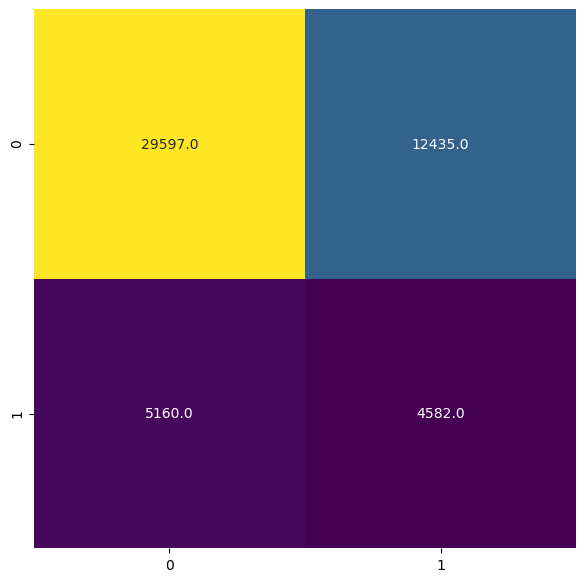

In [30]:
layers = [len(num_col),4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Working_Weekend",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(train_und)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}
')
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

### Oversampling 

In [14]:
under_1=trainingData.filter(col('Working_Weekend') == 1)
under_1 = trainingData.sample(True, 0.3, seed=42)

In [15]:
under_1.count()

36700

In [16]:
oversample_1=trainingData.filter(col('Working_Weekend') == 1)
num_campioni_da_generare = n_0
num_campioni_da_generare=(num_campioni_da_generare-n_1)/n_1 #percentuale 
#print(num_campioni_da_generare)
full_1=oversample_1
#print(full.count())
while num_campioni_da_generare>1:
    oversample_1= oversample_1.unionAll(full_1)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
df_minority_oversampled = full_1.sample(True, num_campioni_da_generare, seed=42)

oversample_1 = oversample_1.unionAll(df_minority_oversampled)

2.347843275059299
1.347843275059299
0.347843275059299


In [17]:
df_over=oversample_1.unionAll(trainingData.filter(col('Working_Weekend') == 0))

In [18]:
df_over.count()

197969

In [19]:
from pyspark.sql import functions as F
g=df_over.groupBy('Working_Weekend').agg(F.count('Working_Weekend').alias('Working_Weekend'))
g=g.sort('Working_Weekend')
g.show()

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=57038Kb max_used=57105Kb free=74033Kb
 bounds [0x00000001089d8000, 0x000000010c238000, 0x00000001109d8000]
 total_blobs=17093 nmethods=16067 adapters=937
 compilation: disabled (not enough contiguous free space left)
+---------------+---------------+
|Working_Weekend|Working_Weekend|
+---------------+---------------+
|              0|          98983|
|              1|          98986|
+---------------+---------------+



In [20]:
train_over=df_over

23/12/13 22:03:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy:0.6583926401666378

Test Error = 0.341607


Precision for class  0 : 85.47%
Recall for class  0 : 69.90%
avg_F1-Score for class  0 : 76.91%
----------------------------
Precision for class  1 : 26.78%
Recall for class  1 : 48.08%
avg_F1-Score for class  1 : 34.40%
----------------------------
[0.7690682938277399, 0.344]
----------------------
avg_F1-Score: 55.65%


<AxesSubplot:>

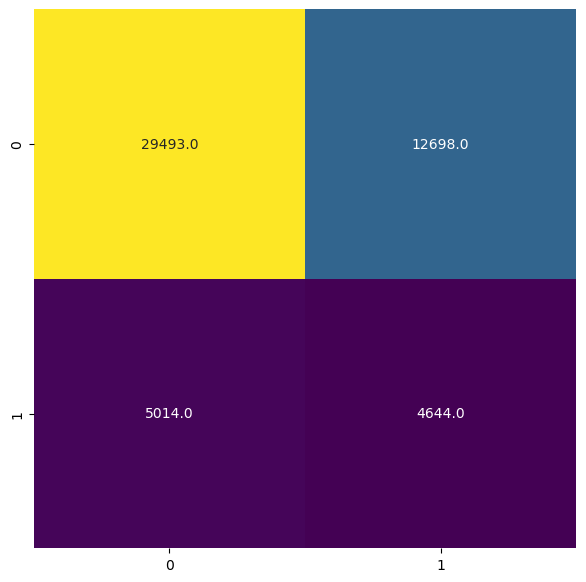

In [21]:
layers = [len(num_col),4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Working_Weekend",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(train_over)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}
')
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)